In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [3]:
paths = ["datasets/faces/s" + str(i) for i in range(1, 41)]
cnt = 0
Data = np.zeros((400, 10304))
labels = np.zeros((400, 1))
for i in range(40):
    labels[i * 10 : (i + 1) * 10] = i + 1
for path in paths:
    files = os.listdir(path)
    for file in files:
        img = Image.open(path + "/" + file)
        np_img = np.array(img)
        np_img = np_img.flatten()
        Data[cnt] = np_img
        cnt += 1

## Data Visualization


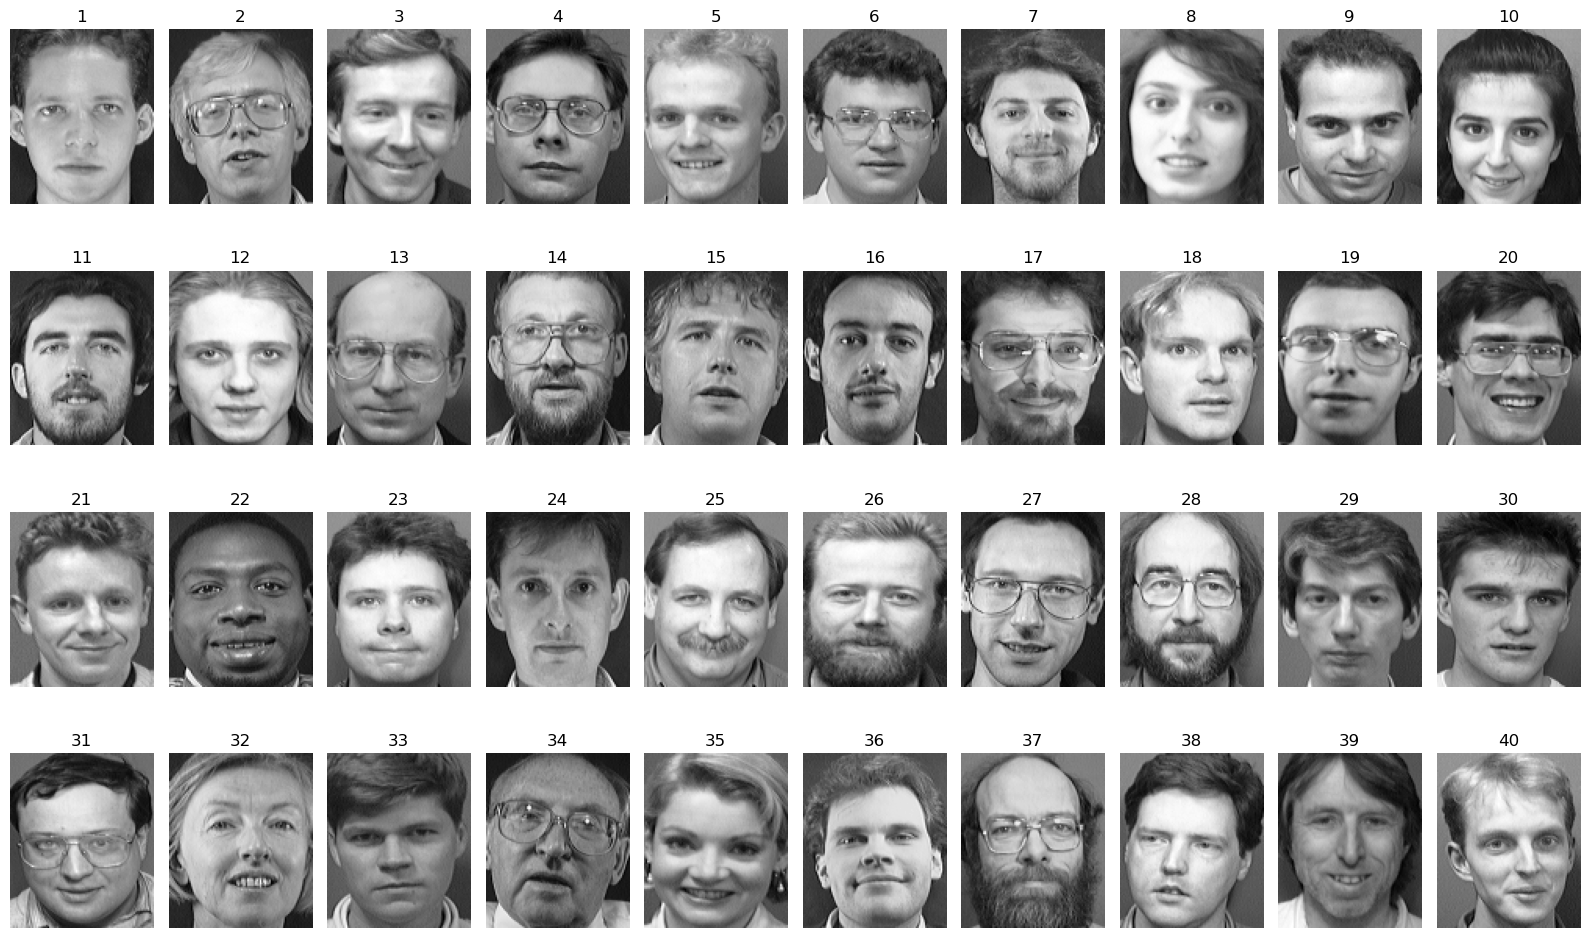

In [4]:
image_height = 112
image_width = 92

fig, axs = plt.subplots(4, 10, figsize=(16, 10))

# Flatten the array of axes
axs = axs.ravel()

for i in range(40):
    image_array = np.reshape(Data[(i) * 10], (image_height, image_width))
    axs[i].imshow(image_array, cmap="gray")
    axs[i].set_title(i + 1)
    axs[i].axis("off")

plt.tight_layout()
plt.show()

## Spliting the Dataset

In [5]:
X_train = Data[0::2]
X_test = Data[1::2]
y_train = labels[0::2]
y_test = labels[1::2]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(200, 10304)
(200, 10304)
(200, 1)
(200, 1)


# PCA

In [6]:
def get_PCA(training_data, alpha):
    # Compute the mean of the training data
    mean_face = np.mean(training_data, axis=0)
    # subtract the mean from the training data
    training_data_centralized = training_data - mean_face
    # compute the covariance matrix
    cov_matrix = training_data_centralized @ training_data_centralized.T
    # compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    # sort the eigenvectors descindigly by eigenvalues
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    # restore the original eigenvectors
    eigenvectors_converted = training_data_centralized.T @ eigenvectors
    # normalize the eigenvectors_converted
    eigenfaces = eigenvectors_converted / np.linalg.norm(eigenvectors_converted, axis=0)
    # compute the number of components to keep
    sum = 0
    no_components = 0
    for i in range(len(eigenvalues)):
        sum += eigenvalues[i]
        no_components += 1
        if sum / np.sum(eigenvalues) >= alpha:
            break
    # project the training data on the eigenfaces
    return mean_face, eigenfaces[:, :no_components]


mean_face, eigenfaces = get_PCA(X_train, 0.8)
print(eigenfaces.shape)

(10304, 36)


## Projection Training Data and Test Date

In [7]:
def PCA_Projected_data(training_data,testing_data,mean_face, eigenfaces):
    X_train_centered = training_data - mean_face
    X_train_projected = X_train_centered @ eigenfaces
    X_test_centered = testing_data - mean_face
    X_test_projected = X_test_centered @ eigenfaces
    return X_train_projected, X_test_projected

## Plotting the first 5 eigen faces

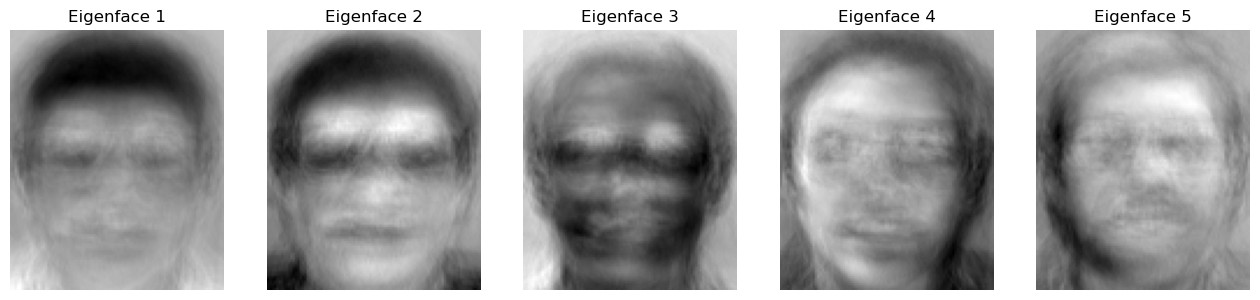

In [8]:
_, eigenfaces = get_PCA(X_train, 0.95)
# plotting first 5 eigenfaces
fig, axs = plt.subplots(1, 5, figsize=(16, 10))
for i in range(5):
    image_array = np.reshape(eigenfaces[:, i], (image_height, image_width))
    axs[i].imshow(image_array, cmap="gray")
    axs[i].set_title("Eigenface " + str(i + 1))
    axs[i].axis("off")

## Test PCA

In [9]:
def Test_PCA(training_data,testing_data,training_labels,testing_labes,alpha, k):
    mean_face, eigenfaces = get_PCA(training_data, alpha)
    X_train_pca, X_test_pca = PCA_Projected_data(training_data,testing_data,mean_face, eigenfaces)
    knn = KNeighborsClassifier(k, weights="distance")
    knn.fit(X_train_pca, training_labels.ravel())
    y_pred = knn.predict(X_test_pca)
    accuracy = accuracy_score(testing_labes, y_pred.ravel())
    return accuracy


print("PCA Accuracy: " + str(Test_PCA(X_train,X_test,y_train,y_test,0.85, 1)))

PCA Accuracy: 0.94


## Classifier Tuning for PCA

In [10]:
alphas = [0.8, 0.85, 0.9, 0.95]
k_values = [1, 3, 5, 7, 9]
df = pd.DataFrame(index=alphas, columns=k_values)
for num_dominant_eigen_vectors in alphas:
    for k in k_values:
        accuracy = Test_PCA(X_train,X_test,y_train,y_test,num_dominant_eigen_vectors, k)
        df.loc[num_dominant_eigen_vectors, k] = accuracy

df

,1,3,5,7,9
0.80,0.94,0.905,0.895,0.88,0.835
0.85,0.94,0.9,0.895,0.855,0.83
0.90,0.94,0.905,0.89,0.855,0.815
0.95,0.93,0.9,0.865,0.83,0.805


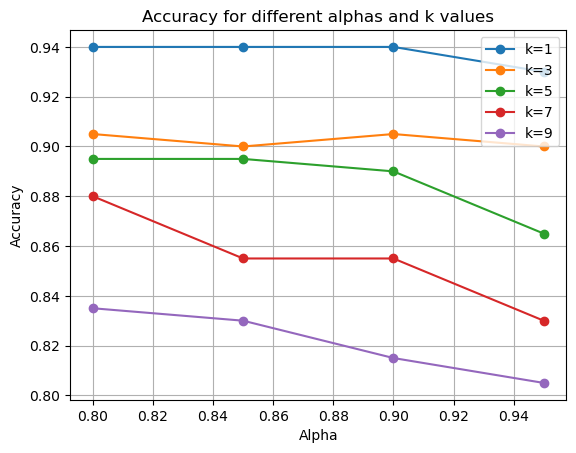

In [11]:
for k in k_values:
    plt.plot(df.index, df[k], marker="o", label=f"k={k}")

plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.title("Accuracy for different alphas and k values")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

# LDA

In [12]:
def get_LDA(X_train, y_train):
    y_train = np.squeeze(y_train)
    class_means = np.array([np.mean(X_train[y_train == i], axis=0) for i in range(1, 41)])
    class_sizes = np.array([np.sum(y_train == i) for i in range(1, 41)])

    # Compute overall mean
    overall_mean = np.mean(X_train, axis=0)

    # Compute within-class scatter matrix
    S_W = np.zeros((X_train.shape[1], X_train.shape[1]))
    for i in range(1, 41):
        # Use boolean index to select rows from X_train
        class_data = X_train[y_train == i]
        centered_data = class_data - class_means[i - 1]
        S_W += np.dot(centered_data.T, centered_data) 

    # # Regularize S_W
    S_W += 1e-7 * np.identity(X_train.shape[1])

    # Compute between-class scatter matrix
    S_B = np.zeros((X_train.shape[1], X_train.shape[1]))
    for i in range(1, 41):
        # Use boolean index to select rows from X_train
        class_data = X_train[y_train == i]
        class_diff = class_means[i - 1] - overall_mean
        S_B += class_sizes[i - 1] * np.outer(class_diff, class_diff)

    # Solve generalized eigenvalue problem
    eigenvalues, eigenvectors = np.linalg.eig(np.dot(np.linalg.inv(S_W), S_B))

    # Sort eigenvalues and eigenvectors
    idx = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, idx]

    # Take only the dominant eigenvectors
    projection_matrix = sorted_eigenvectors[:, :39]
    return np.real(projection_matrix)

## The Projection matrix of LDA

In [13]:
LDA_projection_matrix = get_LDA(X_train,y_train)
print(LDA_projection_matrix.shape)

(10304, 39)


In [14]:
## LDA PRojection

def LDA_projected_data(training_data,test_data,projection_matrix):
    projected_X_train = np.dot(training_data, projection_matrix)
    projected_X_test = np.dot(test_data, projection_matrix)
    return projected_X_train, projected_X_test

## Test LDA

In [15]:
def Test_LDA(k):
    projected_X_train, projected_X_test = LDA_projected_data(X_train,X_test,LDA_projection_matrix)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(projected_X_train, y_train.ravel())
    y_pred = knn.predict(projected_X_test)
    accuracy = accuracy_score(y_test, y_pred.ravel())
    return accuracy


print("LDA Accuracy: " + str(Test_LDA(1)))

LDA Accuracy: 0.95


## Classifier Tuning for LDA

In [16]:
k_values = [1, 3, 5, 7, 9]

# Initialize a list to store the results
results = []
projected_X_train, projected_X_test = LDA_projected_data(X_train,X_test,LDA_projection_matrix)
# Loop over the values of k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, weights="distance")
    knn.fit(projected_X_train, y_train.ravel())
    y_pred = knn.predict(projected_X_test)
    accuracy = accuracy_score(y_test, y_pred.ravel())
    results.append({"accuracy": accuracy})

# Convert the results to a DataFrame
df = pd.DataFrame(results, index=k_values)
df.index.name = "k"
df

,accuracy
k,
1,0.95
3,0.95
5,0.95
7,0.95
9,0.95


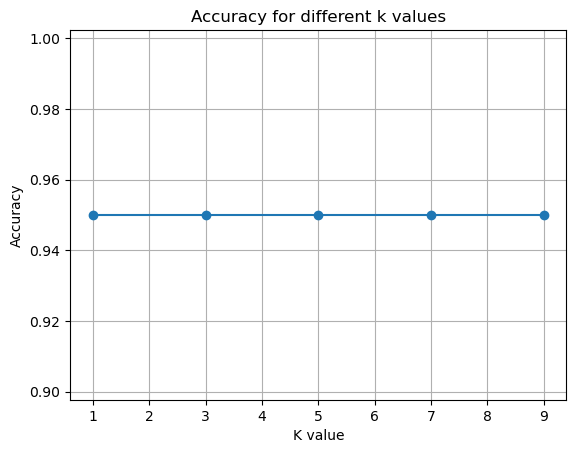

In [17]:
plt.plot(df, marker="o")
plt.xlabel("K value")
plt.ylabel("Accuracy")
plt.title("Accuracy for different k values")
plt.grid(True)
plt.show()

# Comparison between PCA and LDA

### Accuracy of PCA vs LDA w.r.t k (number of nearest neighbours)

In [18]:
alpha = [0.8, 0.85, 0.9, 0.95]
k_values = [1, 3, 5, 7, 9]
variants = [
    "PCA α = 0.8",
    "PCA α = 0.85",
    "PCA α = 0.9",
    "PCA α = 0.95",
    "LDA",
]
df = pd.DataFrame(index=variants, columns=k_values)
for num_dominant_eigen_vectors in alphas:
    for k in k_values:
        for i in range(4):
            pca_accuracy = Test_PCA(X_train,X_test,y_train,y_test,alpha[i], k)
            df.loc[variants[i], k] = str(pca_accuracy * 100) + "%"
        lda_accuracy = Test_LDA(k)
        df.loc["LDA", k] = str(lda_accuracy * 100) + "%"
df

,1,3,5,7,9
PCA α = 0.8,94.0%,90.5%,89.5%,88.0%,83.5%
PCA α = 0.85,94.0%,90.0%,89.5%,85.5%,83.0%
PCA α = 0.9,94.0%,90.5%,89.0%,85.5%,81.5%
PCA α = 0.95,93.0%,90.0%,86.5%,83.0%,80.5%
LDA,95.0%,95.0%,95.0%,95.0%,95.0%


## Splitting Test and Train Data (70-30 ratio)

In [19]:
def split_data(data,labels):
    bonus_x_train = np.zeros((280,10304))
    bonus_x_test = np.zeros((120,10304))
    bonus_y_train = np.zeros((280,1))
    bonus_y_test = np.zeros((120,1))
    # split each person's data into 7 training images and 3 testing images
    for  i in range (40):
        bonus_x_train[i*7:(i+1)*7] = data[i*10:i*10+7]
        bonus_x_test[i*3:(i+1)*3] = data[i*10+7:i*10+10]
        bonus_y_train[i*7:(i+1)*7] = labels[i*10:i*10+7]
        bonus_y_test[i*3:(i+1)*3] = labels[i*10+7:i*10+10]
    # shuffle the data
    indices = np.arange(280)
    np.random.shuffle(indices)
    bonus_x_train = bonus_x_train[indices]
    bonus_y_train = bonus_y_train[indices]   
    return bonus_x_train,bonus_x_test,bonus_y_train,bonus_y_test
bonus_x_train,bonus_x_test,bonus_y_train,bonus_y_test = split_data(Data,labels)

In [20]:
bonus_x_train, bonus_x_test, bonus_y_train, bonus_y_test = split_data(Data, labels)

In [21]:
mean_face, eigenfaces = get_PCA(bonus_x_train, 0.85)
X_train_pca, X_test_pca = PCA_Projected_data(bonus_x_train,bonus_x_test,mean_face, eigenfaces)
knn = KNeighborsClassifier(1, weights="distance")
knn.fit(X_train_pca, bonus_y_train.ravel())
y_pred = knn.predict(X_test_pca)
accuracy = accuracy_score(bonus_y_test, y_pred.ravel())
print("PCA Accuracy: " + str(accuracy))

PCA Accuracy: 0.9583333333333334


## Comaprison between Oridinary Split and Train SPlit in PCA

In [22]:
alpha = [0.8, 0.85, 0.9, 0.95]
k=1
df = pd.DataFrame(index=alpha, columns=["Original Split", "Bonus Split"])
for num_dominant_eigen_vectors in alpha:
    pca_accuracy = Test_PCA(X_train,X_test,y_train,y_test,num_dominant_eigen_vectors, k)
    df.loc[num_dominant_eigen_vectors, "Original Split"] = pca_accuracy
    bonus_pca_accuracy = Test_PCA(bonus_x_train,bonus_x_test,bonus_y_train,bonus_y_test,num_dominant_eigen_vectors, k)
    df.loc[num_dominant_eigen_vectors, "Bonus Split"] = bonus_pca_accuracy
df    


,Original Split,Bonus Split
0.80,0.94,0.966667
0.85,0.94,0.958333
0.90,0.94,0.95
0.95,0.93,0.941667


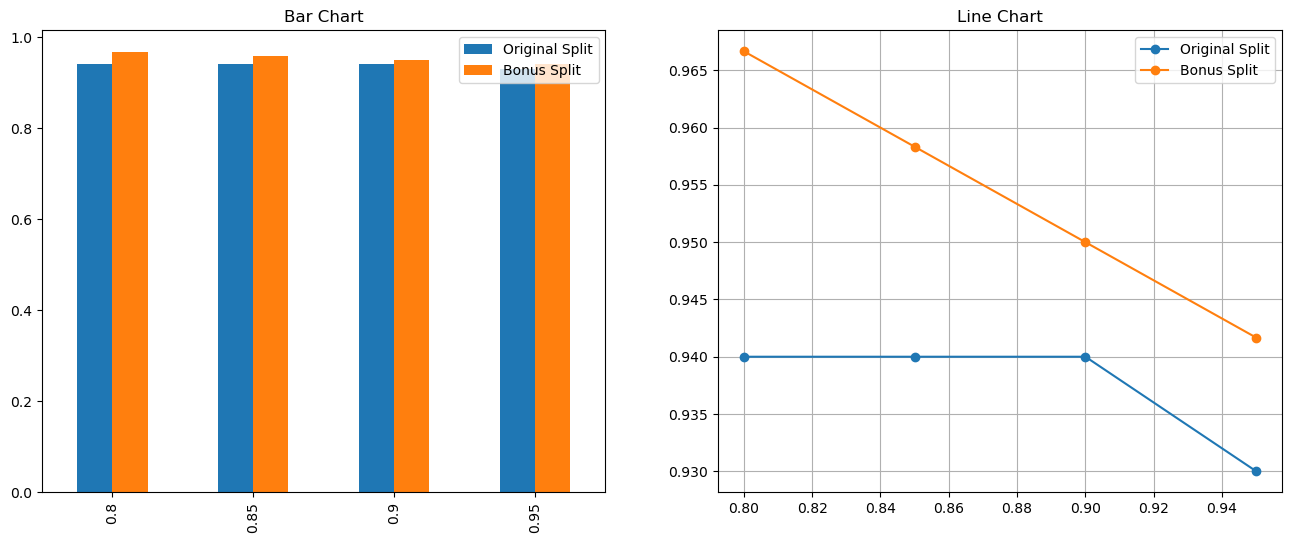

In [23]:
# plot the df as
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
df.plot(kind="bar", ax=ax[0])
df.plot(kind="line", ax=ax[1], marker="o")
ax[0].set_title("Bar Chart")
ax[1].set_title("Line Chart")
plt.grid(True)
plt.show()

## Comparison between Ordinart SPlit and Bonus SPlit in LDA

In [24]:
def get_acc(X_train, X_test, y_train, y_test, k):
    knn = KNeighborsClassifier(k, weights="distance")
    knn.fit(X_train, y_train.ravel())
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred.ravel())
    return accuracy
Bonus_LDA_projection_matrix = get_LDA(bonus_x_train, bonus_y_train)
projected_X_train, projected_X_test = LDA_projected_data(bonus_x_train,bonus_x_test,LDA_projection_matrix)
acc_Lda_07 = get_acc(projected_X_train, projected_X_test, bonus_y_train, bonus_y_test, 1)
print("LDA Accuracy: " + str(acc_Lda_07))

LDA Accuracy: 0.975


In [25]:
df = pd.DataFrame(index=[], columns=["Original Split", "Bonus Split"])
df.loc["LDA", "Original Split"] = Test_LDA(1)
df.loc["LDA", "Bonus Split"] = acc_Lda_07
df

,Original Split,Bonus Split
LDA,0.95,0.975


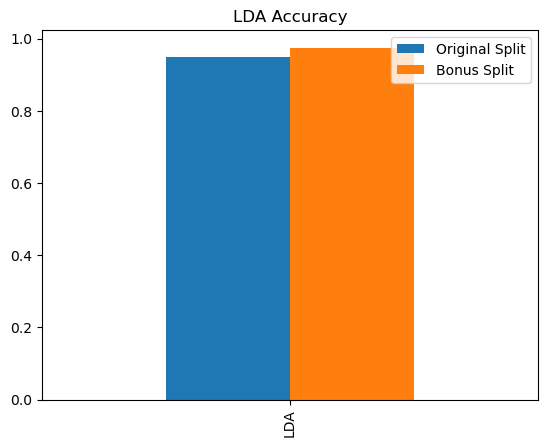

In [26]:
df.plot(kind="bar")
plt.title("LDA Accuracy")
plt.show()

# Variants of PCA

## Polynomial Kernel PCA

In [27]:
def Test_Polynomial_Kernel_PCA(no_of_components, k):
    kpca = KernelPCA(n_components=no_of_components, kernel="poly")
    X_train_kpca = kpca.fit_transform(X_train)
    X_test_kpca = kpca.transform(X_test)
    knn = KNeighborsClassifier(k, weights="distance")
    knn.fit(X_train_kpca, y_train.ravel())
    y_pred = knn.predict(X_test_kpca)
    accuracy = accuracy_score(y_test, y_pred.ravel())
    return accuracy


print("Polynomial Kernel PCA Accuracy: " + str(Test_Polynomial_Kernel_PCA(36, 1)))

Polynomial Kernel PCA Accuracy: 0.935


## Comparison between Polynomial Kernel PCA and My Amazing PCA

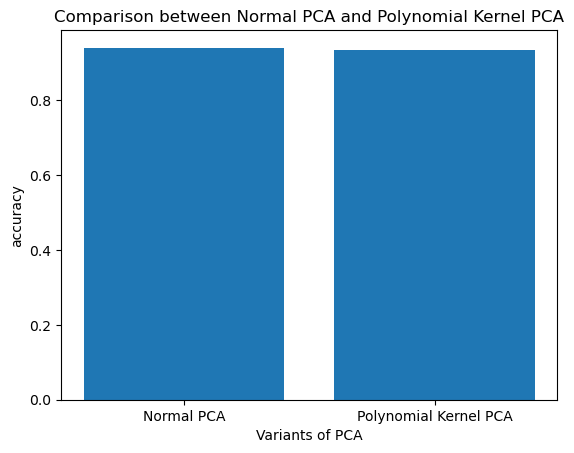

In [29]:
categories = ["Normal PCA", "Polynomial Kernel PCA"]
values = [Test_PCA(X_train,X_test,y_train,y_test,0.8, 1), Test_Polynomial_Kernel_PCA(36, 1)]

# Create bar chart
plt.bar(categories, values)

# Add labels and title
plt.xlabel("Variants of PCA")
plt.ylabel("accuracy")
plt.title("Comparison between Normal PCA and Polynomial Kernel PCA")

# Show the plot
plt.show()

# Variants of LDA

## Shrinkage LDA

In [30]:
def Test_Shrinkage_LDA(k):
    lda = LinearDiscriminantAnalysis(solver="eigen", shrinkage="auto")
    lda.fit(X_train, y_train.ravel())
    X_train_projection = lda.transform(X_train)
    X_test_projection = lda.transform(X_test)
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_projection, y_train.ravel())
    y_pred = knn.predict(X_test_projection)
    accuracy = accuracy_score(y_test, y_pred.ravel())
    return accuracy


print("Shrinkage LDA Accuracy: " + str(Test_Shrinkage_LDA(1)))

Shrinkage LDA Accuracy: 0.95


## Comparison between Shrinkage LDA and Normal LDA

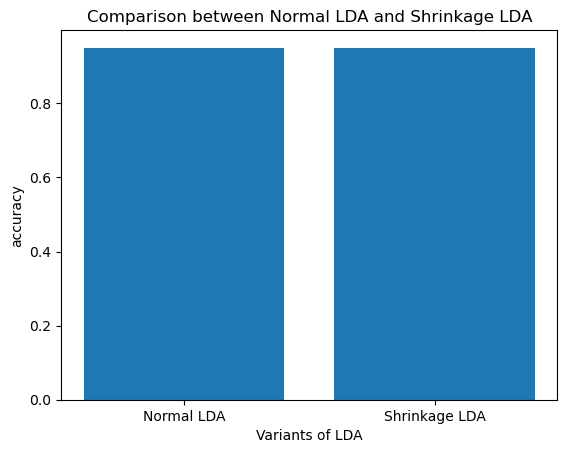

In [31]:
categories = ["Normal LDA", "Shrinkage LDA"]
values = [Test_LDA(1), 0.95]

# Create bar chart
plt.bar(categories, values)

# Add labels and title
plt.xlabel("Variants of LDA")
plt.ylabel("accuracy")
plt.title("Comparison between Normal LDA and Shrinkage LDA")

# Show the plot
plt.show()